# Attention

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone -b att https://github.com/phamlinh2111/KLTN.git /content/KLTN

Cloning into '/content/KLTN'...
remote: Enumerating objects: 471, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 471 (delta 68), reused 70 (delta 66), pack-reused 393 (from 1)
Receiving objects: 100% (471/471), 98.88 MiB | 32.13 MiB/s, done.
Resolving deltas: 100% (255/255), done.


In [ ]:
!rm -rf /content/KLTN

In [3]:
%cd /content/KLTN

/content/KLTN


In [4]:
!pip install tensorboardX

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 2.7 MB/s eta 0:00:00


In [5]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.9 MB/s eta 0:00:00
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16426 sha256=c6bc333e765453f8edd7c05d11b9806f45ab07499289ae6a8

In [6]:
!pip install av


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.7/39.7 MB 19.6 MB/s eta 0:00:00


In [7]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import offsetbox
import sklearn.manifold
import numpy as np
import torch
from torchvision.transforms import ToPILImage
from PIL import Image,ImageChops
from tqdm.notebook import tqdm

import matplotlib

import sys
sys.path.append('..')

from isplutils import split, data, utils
from architectures import fornet

In [8]:
splits = split.make_splits(
    ffpp_df='/content/drive/MyDrive/KLTN/extracted_faces_df',
    ffpp_dir='/content/drive/MyDrive/KLTN/extracted_faces/',
    dbs={'test': ['ff-c23-720-140-140']}
)
df = splits['test']['ff-c23-720-140-140'][0]
root = Path(splits['test']['ff-c23-720-140-140'][1])

In [9]:
net_model = 'EfficientNetAutoAttB4'
train_db = 'FFPP'

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
face_size = 224
frames_per_video = 32

In [20]:
model_path = "/content/drive/MyDrive/KLTN/model_attv6/net-EfficientNetAutoAttB4_traindb-ff-c23-720-140-140_face-scale_size-224_seed-41/bestval.pth"
net = getattr(fornet, net_model)().eval().to(device)
checkpoint = torch.load(model_path, map_location=device)
net.load_state_dict(checkpoint['net'])

Loaded pretrained weights for efficientnet-b4


In [21]:
face_size = 224
transformer = utils.get_transformer(patch_size=face_size,
                                    net_normalizer=net.get_normalizer(), train=False)

/content/KLTN/isplutils/utils.py:102: UserWarning: Argument(s) 'value, always_apply' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=patch_size, min_width=patch_size,
/content/KLTN/isplutils/utils.py:104: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  A.Resize(height=patch_size, width=patch_size, always_apply=True),


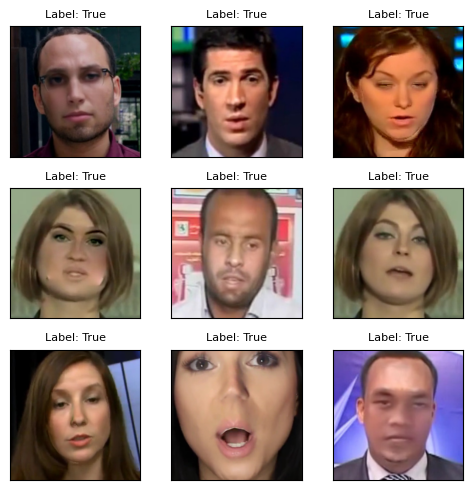

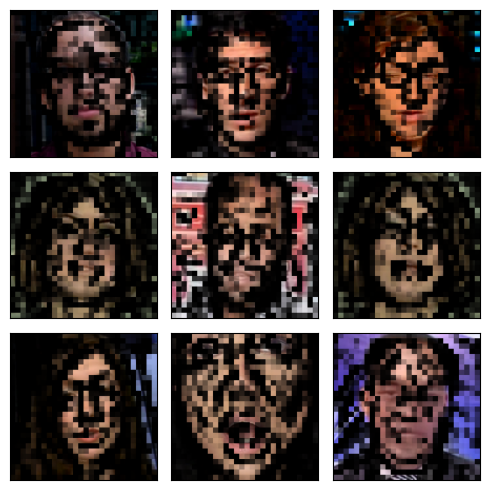

In [22]:
%matplotlib inline

fig_im,axis_im = plt.subplots(3,3,figsize=(5,5))
fig_att,axis_att = plt.subplots(3,3,figsize=(5,5))
axis_im = axis_im.reshape(-1)
axis_att = axis_att.reshape(-1)

df_fake = df[df['label'] == 1]
# df_real = df[df['label'] == 0]

#records = df_fake.sample(len(axis_im), random_state=41)
records = df_fake.sample(len(axis_im))

for idx,(ax_im,ax_att) in enumerate(zip(axis_im,axis_att)):
    record = records.iloc[idx]
    frame_im = Image.open(root.joinpath(record.name))
    bb = record['left'], record['top'], record['right'], record['bottom']
    face_im = utils.extract_bb(frame_im, bb=bb, size=face_size)
    face_t = data.load_face(record=record,
                          root=root,
                          size=face_size,
                          transformer=transformer)
    with torch.no_grad():
        if hasattr(net,'feat_ext'):
            att = net.feat_ext.get_attention(face_t.unsqueeze(0))[0].cpu()
        else:
            att = net.get_attention(face_t.unsqueeze(0))[0].cpu()
    att_img = ToPILImage()(att)
    att_img = att_img.resize(face_im.size, resample=Image.NEAREST).convert('RGB')
    face_att_img = ImageChops.multiply(face_im, att_img)
    ax_im.imshow(face_im)
    ax_im.set_xticks([]); ax_im.set_yticks([])
    ax_im.set_title(f"Label: {record['label']}", fontsize=8)
    ax_att.imshow(face_att_img)
    ax_att.set_xticks([]); ax_att.set_yticks([])

fig_im.tight_layout()
fig_att.tight_layout()


In [ ]:
model_path = "/content/drive/MyDrive/KLTN/model_attv5/net-EfficientNetAutoAttB4_traindb-ff-c23-720-140-140_face-scale_size-224_seed-41/bestval.pth"
net = getattr(fornet, net_model)().eval().to(device)
checkpoint = torch.load(model_path, map_location=device)
net.load_state_dict(checkpoint['net'])

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:00<00:00, 173MB/s]


Loaded pretrained weights for efficientnet-b4


<All keys matched successfully>

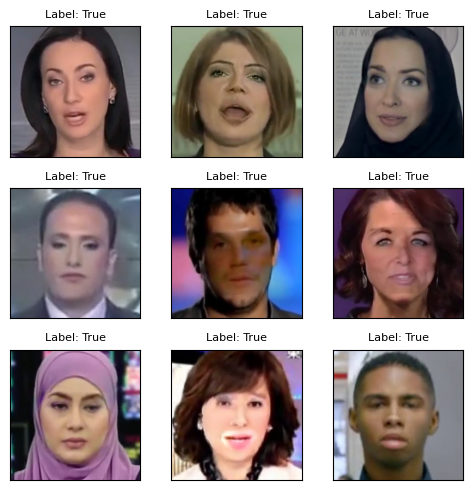

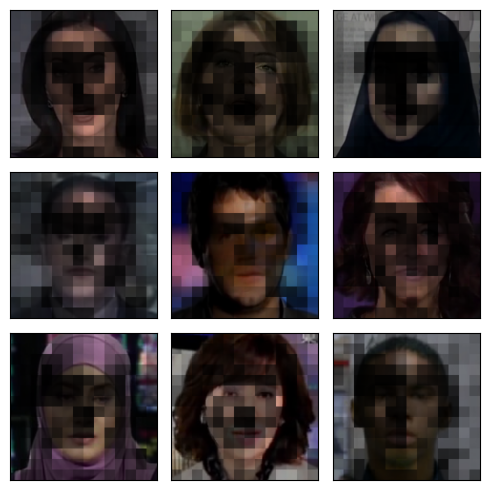

In [ ]:
%matplotlib inline

fig_im,axis_im = plt.subplots(3,3,figsize=(5,5))
fig_att,axis_att = plt.subplots(3,3,figsize=(5,5))
axis_im = axis_im.reshape(-1)
axis_att = axis_att.reshape(-1)

df_fake = df[df['label'] == 1]
# df_real = df[df['label'] == 0]

#records = df_fake.sample(len(axis_im), random_state=41)
records = df_fake.sample(len(axis_im))

for idx,(ax_im,ax_att) in enumerate(zip(axis_im,axis_att)):
    record = records.iloc[idx]
    frame_im = Image.open(root.joinpath(record.name))
    bb = record['left'], record['top'], record['right'], record['bottom']
    face_im = utils.extract_bb(frame_im, bb=bb, size=face_size)
    face_t = data.load_face(record=record,
                          root=root,
                          size=face_size,
                          transformer=transformer)
    with torch.no_grad():
        if hasattr(net,'feat_ext'):
            att = net.feat_ext.get_attention(face_t.unsqueeze(0))[0].cpu()
        else:
            att = net.get_attention(face_t.unsqueeze(0))[0].cpu()
    att_img = ToPILImage()(att)
    att_img = att_img.resize(face_im.size, resample=Image.NEAREST).convert('RGB')
    face_att_img = ImageChops.multiply(face_im, att_img)
    ax_im.imshow(face_im)
    ax_im.set_xticks([]); ax_im.set_yticks([])
    ax_im.set_title(f"Label: {record['label']}", fontsize=8)
    ax_att.imshow(face_att_img)
    ax_att.set_xticks([]); ax_att.set_yticks([])

fig_im.tight_layout()
fig_att.tight_layout()